Import necessary libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import mean_squared_error

Load the data

In [2]:
# load mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension
x_test = np.expand_dims(x_test, -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#### Build the the convolutional auto encoder model

The encoder consists of 3 convolutional layers with max pooling and the decoder consists of 3 convolutional layers with up sampling. The first layer of the encoder has 32 filters, the second layer has 64 filters and the third layer has one filter for the latent representation. All the convolutional layers have a kernel size of 3x3 and a stride of 1. The max pooling layers have a pool size of 2x2.

The decoder consists of 3 convolutional layers with up sampling. 

The first layer of the decoder has 64 filters, the second layer has 32 filters and the third layer has 1 filter for the reconstructed image.

In [3]:
# I have also tried U-Net architecture - works better, convergates in 1st
# epoch, just the epoch takes longer. But the teacher wanted us to design
# our own architecture so I think its fine to rather continue with this one

def build_cae():
    # encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    latent = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(x)

    # decoder
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(latent)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    return models.Model(encoder_input, decoder_output)

In [4]:
# code to construcst dae
def build_dae():
    # encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    latent = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    # decoder
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(latent)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    return models.Model(encoder_input, decoder_output)


In [7]:
# evaluation functions

def evaluate_model(model, x_test, x_test_noisy=None):
    x_test_input = x_test_noisy if x_test_noisy is not None else x_test
    x_reconstructed = model.predict(x_test_input)
    mse = mean_squared_error(x_test.flatten(), x_reconstructed.flatten())
    return mse

def plot_loss(history, title):
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def visualize_reconstruction(model, x_test, n=10):
    x_reconstructed = model.predict(x_test)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # original
        plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].squeeze(), cmap="gray")
        plt.axis("off")
        # reconstructed
        plt.subplot(2, n, i + n + 1)
        plt.imshow(x_reconstructed[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

In [19]:
# training parameters
learning_rate = 1e-3
optimizer = tf.keras.optimizers.AdamW(learning_rate, weight_decay=1e-5)
optimizer2 = tf.keras.optimizers.Adam(learning_rate)

cae = build_cae()

# compile model
cae.compile(optimizer=optimizer, loss='binary_crossentropy')

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train model
cae_history = cae.fit(x_train, x_train,
                      epochs=10,  # More epochs with early stopping
                      batch_size=256,
                      validation_data=(x_test, x_test),
                      callbacks=[early_stopping])

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 0.3041 - val_loss: 0.0983
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 47s 200ms/step - loss: 0.0960 - val_loss: 0.0885
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - loss: 0.0885 - val_loss: 0.0846
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0850 - val_loss: 0.0829
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - loss: 0.0832 - val_loss: 0.0816
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.0819 - val_loss: 0.0804
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.0811 - val_loss: 0.0797
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0804 - val_loss: 0.0790
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 0.0796 - val_loss: 0.0783
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.0792 - val_loss: 0.0779


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
CAE MSE: 0.005655072629451752


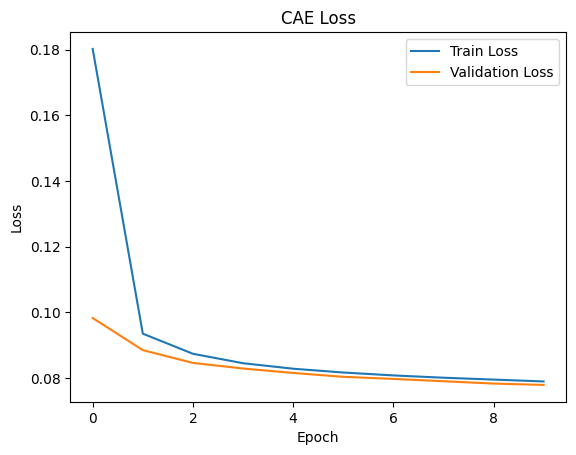

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


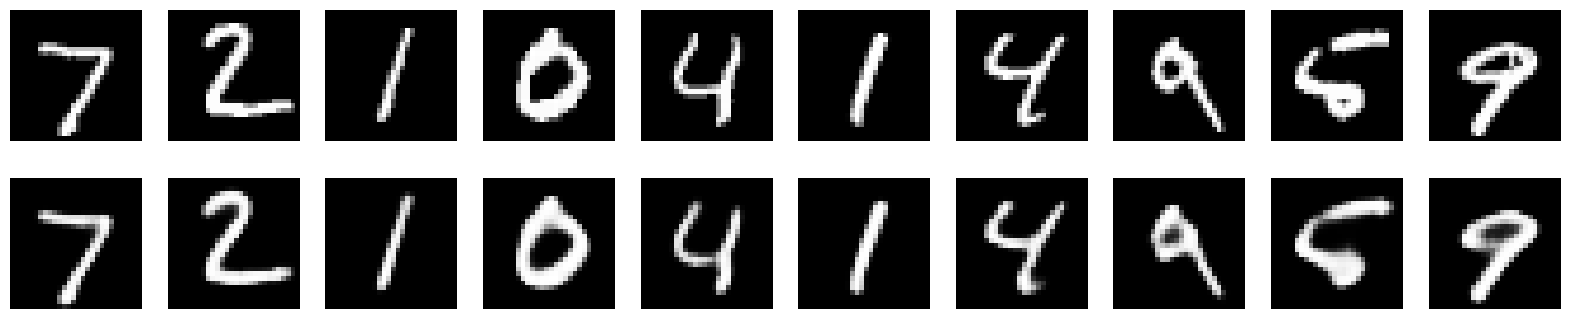

In [20]:
cae_mse = evaluate_model(cae, x_test)
print(f"CAE MSE: {cae_mse}")
plot_loss(cae_history, "CAE Loss")
visualize_reconstruction(cae, x_test)

# I quite like the results here, mostly the visualization. You can see that
# it works good, but such small and random model cannot check the little
# mistakes / noise - it recongises and reconstruct 5, but skips the litle gap
# from the original drawing

In [22]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
# add noise for DAE
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# again, mse didn't work but binary crossentropy brings really nice results

dae = build_dae()
dae.compile(optimizer=optimizer, loss="binary_crossentropy")
dae_history = dae.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), batch_size=128, epochs=10)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - loss: 0.2086 - val_loss: 0.1071
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.1063 - val_loss: 0.1023
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.1027 - val_loss: 0.0999
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.1002 - val_loss: 0.0983
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.0988 - val_loss: 0.0974
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.0978 - val_loss: 0.0972
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.0970 - val_loss: 0.0958
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.0965 - val_loss: 0.0953
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - loss: 0.0958 - val_loss: 0.0953
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.0956 - val_loss: 0.0946


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
DAE MSE 0.010475048795342445


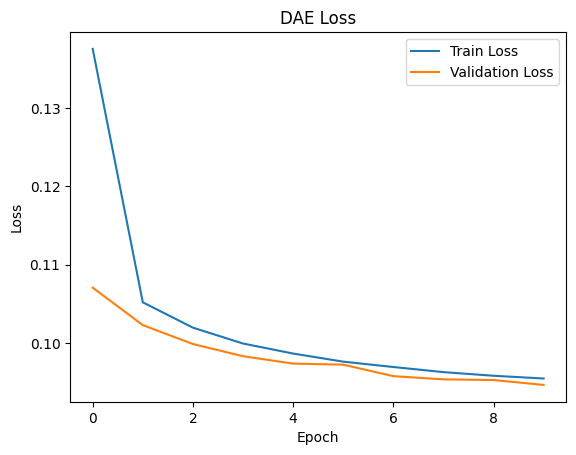

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


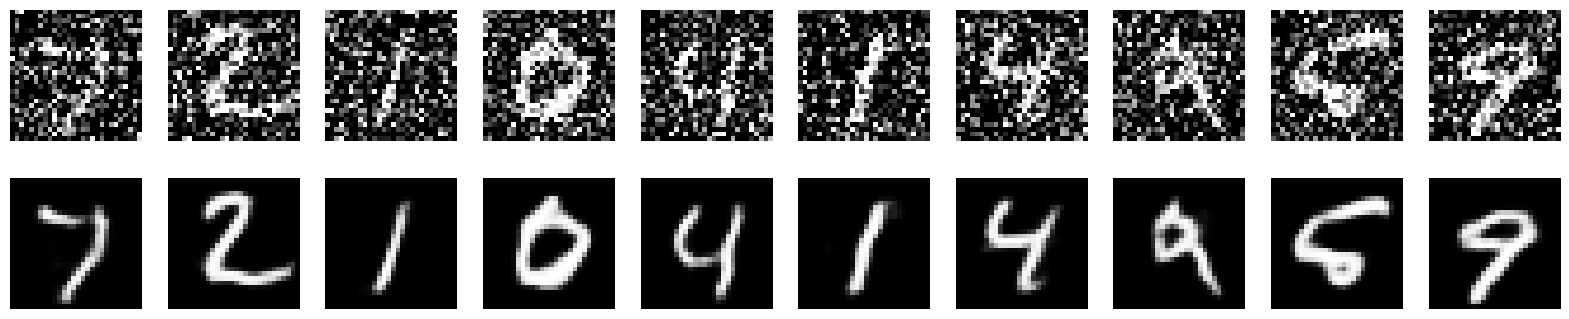

In [23]:
dae_mse = evaluate_model(dae, x_test, x_test_noisy)
print(f"DAE MSE {dae_mse}")
plot_loss(dae_history, "DAE Loss")
visualize_reconstruction(dae, x_test_noisy)

In [40]:
def build_vae():
    latent_dim = 2

    # encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Flatten()(encoder_input)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

    # decoder
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation="relu")(decoder_input)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(28 * 28, activation="sigmoid")(x)
    decoder_output = layers.Reshape((28, 28, 1))(x)
    decoder = models.Model(decoder_input, decoder_output, name="decoder")

    # VAE Model
    vae_output = decoder(encoder(encoder_input)[2])
    vae = models.Model(encoder_input, vae_output, name="vae")

    return vae, encoder, decoder

learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
vae, encoder, decoder = build_vae()
vae.compile(optimizer=optimizer, loss="binary_crossentropy")
vae_history = vae.fit(x_train, x_train, validation_data=(x_test, x_test), batch_size=128, epochs=20)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2948 - val_loss: 0.2130
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2094 - val_loss: 0.1975
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1962 - val_loss: 0.1905
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1901 - val_loss: 0.1869
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1869 - val_loss: 0.1841
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1842 - val_loss: 0.1827
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1822 - val_loss: 0.1811
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1805 - val_loss: 0.1793
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1795 - val_loss: 0.1779
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1779 - val_loss: 0.1770
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1766 - val_loss: 0.1762
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
VAE MSE: 0.037028566002845764


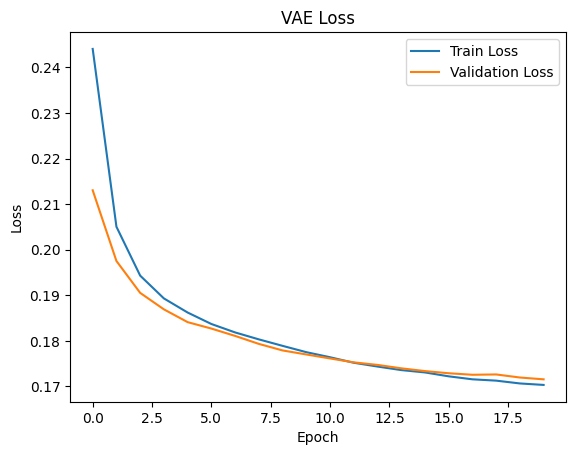

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


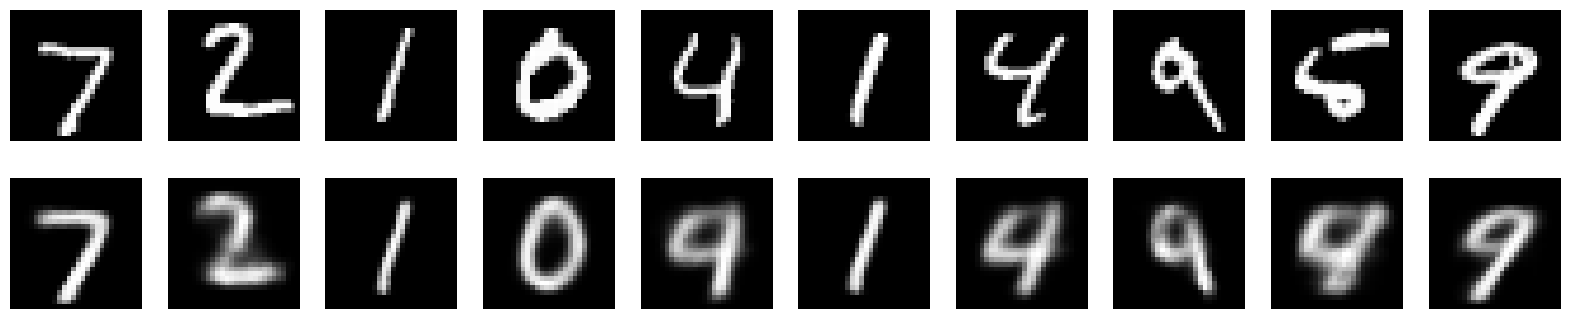

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


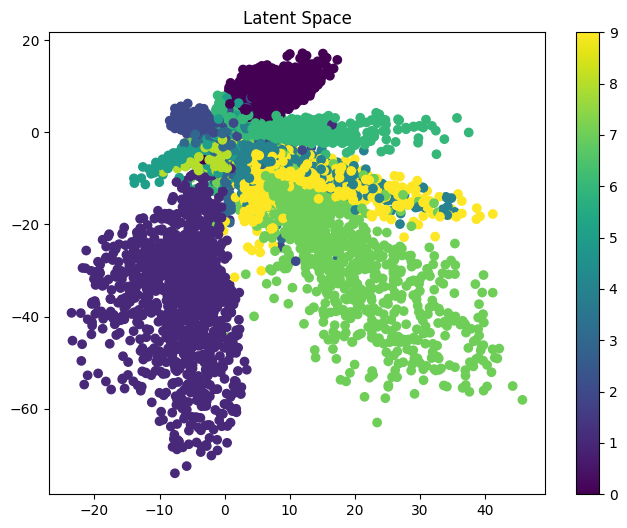

In [41]:
vae_mse = evaluate_model(vae, x_test)
print(f"VAE MSE: {vae_mse}")
plot_loss(vae_history, "VAE Loss")
visualize_reconstruction(vae, x_test)

# latent space visualization for VAE
def visualize_latent_space(vae, x_test, y_test):
    encoder = vae.get_layer("encoder")
    z_mean, _, _ = encoder.predict(x_test)

    # if y_test is not one-hot encoded, use it directly as class labels
    if len(y_test.shape) == 1:  # If it's already in integer format (0-9)
        labels = y_test
    else:  # if it's one-hot encoded, convert it to class labels
        labels = np.argmax(y_test, axis=1)

    # plot latent space
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap="viridis")
    plt.colorbar()
    plt.title("Latent Space")
    plt.show()

# here could be worth visualiza the latent space after 5 epochs and after more,
# the difference is nice and significant
# Visualize the latent space for VAE
visualize_latent_space(vae, x_test, y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


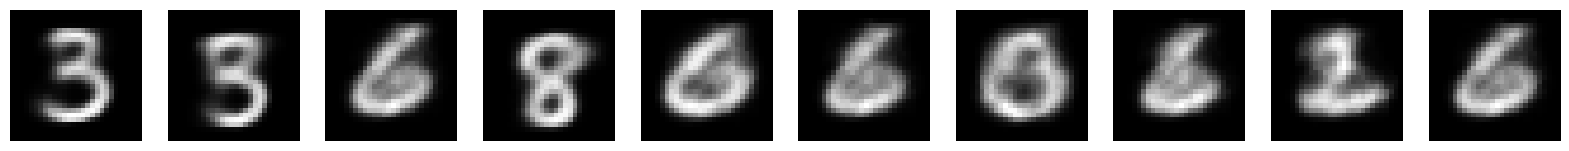

In [43]:
# generate new samples from the latent space
def generate_new_samples(decoder, n_samples=10):
    # randomly sample points from the latent space (using standard normal distribution)
    sampled_latent_vectors = np.random.normal(size=(n_samples, 2))  # latent_dim = 2

    # generate new samples using the decoder
    generated_images = decoder.predict(sampled_latent_vectors)

    # plot the generated samples
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# assuming the decoder is already defined
generate_new_samples(decoder, n_samples=10)